## Import

In [17]:
import pickle
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as tfs
import torch.nn as nn
from torchsummary import summary
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from torchvision.datasets import ImageFolder
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from matplotlib import colors, pyplot as plt
%matplotlib inline
import os
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [18]:
train_dir = Path('/kaggle/input/specialnameof/train')
test_dir = Path('/kaggle/input/specialnameof/testset')

In [19]:
train_files = sorted(list(train_dir.rglob('*.jpg')))
test_files = sorted(list(test_dir.rglob('*.jpg')))


## Prepare data

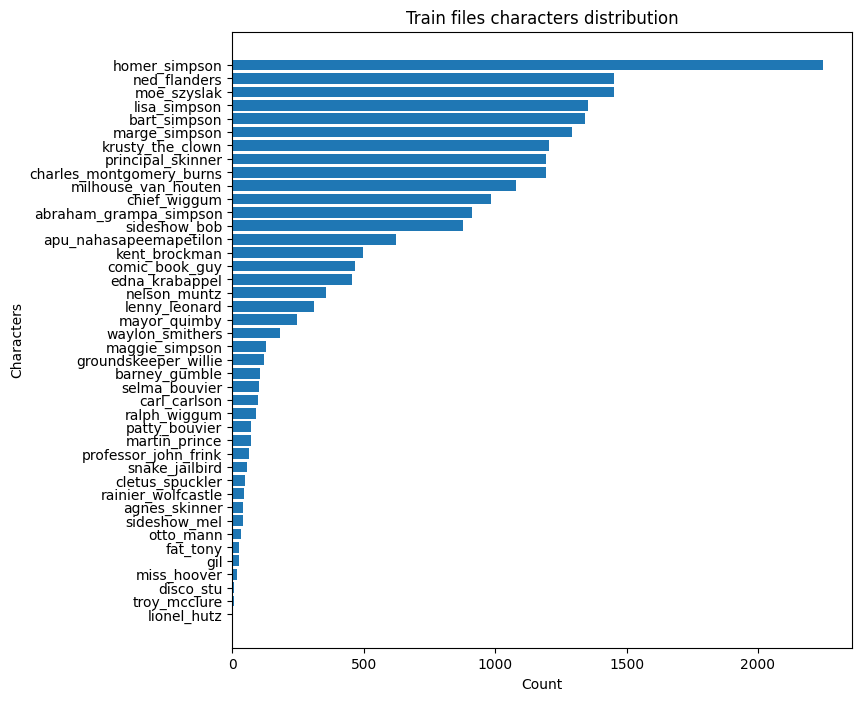

In [20]:
train_labels = [path.parent.name for path in train_files]
counts = pd.Series(train_labels).value_counts()

plt.figure(figsize=(8,8))
plt.barh(counts.keys()[::-1], counts.sort_values(ascending=True))
plt.title('Train files characters distribution')
plt.xlabel('Count')
plt.ylabel('Characters')
plt.show();

In [21]:
modes = ['train', 'test']

class Simpsons(Dataset):
    def __init__(self, files, mode):
        self.files = files
        self.mode = mode
        self.len_ = len(self.files)

        if self.mode not in modes:
            print(f'{self.mode} incorrect. Use actual in {modes}.')
            raise NameError

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('le.pickle', 'wb') as dumped_file:
                pickle.dump(self.label_encoder, dumped_file)

    def __len__(self):
        return self.len_

    def load_img(self, file):
        img = Image.open(file)
        img.load()
        return img

    def __getitem__(self, idx):
        if self.mode == 'test':
            transform = tfs.Compose([
                tfs.Resize(size=(224,224), antialias=True),
                tfs.Lambda(lambda x: np.array(x, dtype='float32') / 255),
                tfs.ToTensor(),
                tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            augmentation = tfs.RandomChoice([
                tfs.Compose([
                    tfs.Resize(size=300, max_size=301),
                    tfs.CenterCrop(size=300),
                    tfs.RandomCrop(250)
                ]),
                tfs.RandomRotation(degrees=(-25,25)),
                tfs.RandomHorizontalFlip(p=1)
            ])
            transform = tfs.Compose([
                augmentation,
                tfs.Resize(size=(224,224), antialias=True),
                tfs.Lambda(lambda x: np.array(x, dtype='float32') / 255),
                tfs.ToTensor(),
                tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

        file = self.files[idx]
        x = self.load_img(file)
        x = transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[idx]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x,y

In [22]:
train_dataset = Simpsons(train_files, mode='train')
test_dataset = Simpsons(test_files, mode='test')

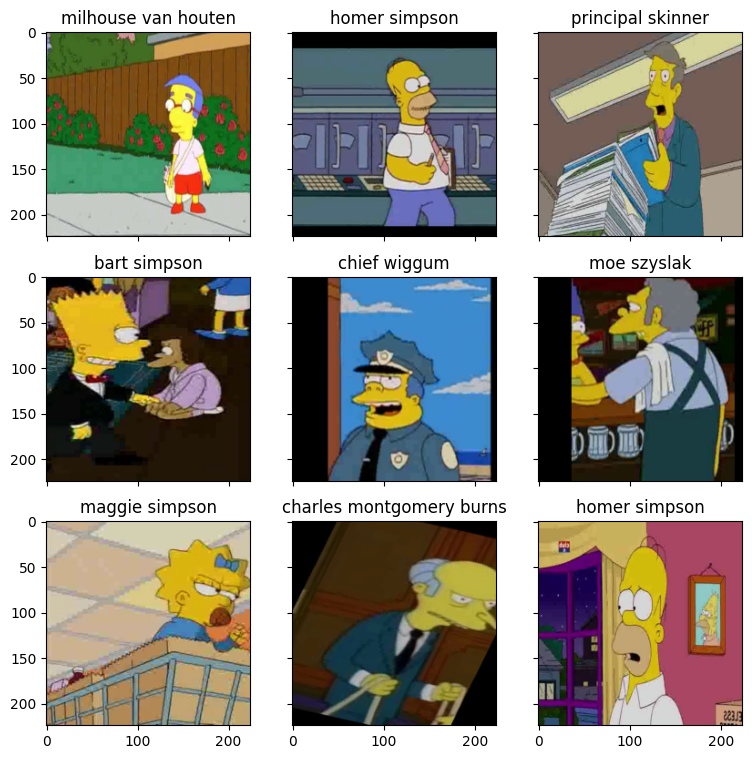

In [23]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
fig, ax = plt.subplots(figsize=(9,9), sharey=True, sharex=True,
                       nrows=3, ncols=3)

for figx in ax.ravel():
    random_character = np.array(np.random.uniform(20000), dtype='int').item()
    img, label = train_dataset[random_character]
    img = img.permute(1,2,0)
    img = img * std + mean
    img = np.clip(img, 0, 1)
    figx.set_title(" ".join(train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    figx.imshow(img)

In [24]:
count_weights = {k: 1/v for k,v in counts.items()}
sample_weights = len(train_files) * [0]

for i, (data, label) in enumerate(tqdm(train_dataset)):
    label_weight = count_weights[train_dataset.label_encoder.inverse_transform([label])[0]]
    sample_weights[i] = label_weight
    
from torch.utils.data import WeightedRandomSampler
train_sampler = WeightedRandomSampler(sample_weights, num_samples=int(counts.max() * len(count_weights)), replacement=True)
train_dataloader = DataLoader(train_dataset, batch_size=128, sampler=train_sampler)

100%|██████████| 20933/20933 [02:02<00:00, 170.59it/s]


In [25]:
def fit_epoch(model, train_dataloader, criterion, optimizer, scheduler):
    running_loss = 0
    running_corrects = 0
    running_data = 0

    for inputs, label in tqdm_notebook(train_dataloader):
        inputs = inputs.to(DEVICE)
        label = label.to(DEVICE)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * label.size(0)
        preds = outputs.argmax(-1)
        running_corrects += (preds == label).sum()
        running_data += label.size(0)


    scheduler.step()
    train_acc = running_corrects / running_data
    train_loss = running_loss / running_data

    return train_loss, train_acc

In [26]:
def train(model,epochs,batch_size,train_dataloader):

    history = []

    log_template = 'Epoch - {ep: 03d}, train loss: {tr_loss: 0.4f}, train acc: {tr_acc: 0.4f}'

    with tqdm(desc='Epoch', total=epochs) as pbar:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_dataloader, criterion, optimizer, scheduler)
            history.append((train_loss, train_acc))
            pbar.update(1)
            tqdm.write(log_template.format(ep=epoch+1, tr_loss = train_loss, tr_acc = train_acc))

    return history

In [27]:
class SimpleCNN(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=2400, out_features=4800),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4800, out_features=4800),
            nn.ReLU(),
        )

        self.fc3 = nn.Sequential(
            nn.Linear(in_features=4800, out_features=42)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [28]:
gpu = torch.cuda.is_available()

if gpu:
    print('CUDA  is available')
    DEVICE = torch.device('cuda')
else:
    print('Not Available CUDA')
    DEVICE = torch.device('cpu')


CUDA  is available


## Train

In [29]:
classes = len(np.unique(train_dataset.labels))

model = SimpleCNN(classes)
model = model.to(DEVICE)

In [30]:
epochs=15
batch_size=128
train

history = train(model,epochs,batch_size,train_dataloader)

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:   7%|▋         | 1/15 [09:41<2:15:39, 581.39s/it]

Epoch -  01, train loss:  1.4943, train acc:  0.5911


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  13%|█▎        | 2/15 [19:30<2:06:58, 586.02s/it]

Epoch -  02, train loss:  0.3629, train acc:  0.8962


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  20%|██        | 3/15 [29:24<1:57:54, 589.53s/it]

Epoch -  03, train loss:  0.2096, train acc:  0.9381


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  27%|██▋       | 4/15 [39:18<1:48:24, 591.34s/it]

Epoch -  04, train loss:  0.1466, train acc:  0.9568


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  33%|███▎      | 5/15 [49:29<1:39:43, 598.37s/it]

Epoch -  05, train loss:  0.1071, train acc:  0.9681


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  40%|████      | 6/15 [59:54<1:31:07, 607.53s/it]

Epoch -  06, train loss:  0.0510, train acc:  0.9853


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  47%|████▋     | 7/15 [1:10:15<1:21:34, 611.82s/it]

Epoch -  07, train loss:  0.0359, train acc:  0.9895


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  53%|█████▎    | 8/15 [1:20:35<1:11:41, 614.56s/it]

Epoch -  08, train loss:  0.0300, train acc:  0.9915


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  60%|██████    | 9/15 [1:31:04<1:01:54, 619.13s/it]

Epoch -  09, train loss:  0.0234, train acc:  0.9933


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  67%|██████▋   | 10/15 [1:41:26<51:39, 619.87s/it] 

Epoch -  10, train loss:  0.0199, train acc:  0.9943


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  73%|███████▎  | 11/15 [1:51:44<41:17, 619.29s/it]

Epoch -  11, train loss:  0.0173, train acc:  0.9947


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  80%|████████  | 12/15 [2:01:52<30:47, 615.82s/it]

Epoch -  12, train loss:  0.0198, train acc:  0.9944


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  87%|████████▋ | 13/15 [2:12:05<20:30, 615.11s/it]

Epoch -  13, train loss:  0.0168, train acc:  0.9953


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  93%|█████████▎| 14/15 [2:22:13<10:12, 612.76s/it]

Epoch -  14, train loss:  0.0176, train acc:  0.9953


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch: 100%|██████████| 15/15 [2:32:16<00:00, 609.08s/it]

Epoch -  15, train loss:  0.0158, train acc:  0.9955


In [31]:
def predict(model, test_dataloader):

    logits = []

    with torch.no_grad():
        for data in tqdm(test_dataloader):
            data = data.to(DEVICE)
            model.eval()
            outputs = model(data)
            logits.append(outputs)

    return logits

In [32]:
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=128)
predictions = predict(model, test_dataloader)
preds = nn.functional.softmax(torch.cat(predictions), dim=-1).argmax(-1).cpu().numpy()
predictions = train_dataset.label_encoder.inverse_transform(preds)
id_lab = [path.name for path in test_files]
pd.DataFrame({'Id': id_lab, 'Expected': predictions}).to_csv('preds1.csv', index=False)

100%|██████████| 8/8 [00:04<00:00,  1.86it/s]
